# <center> <h1> Testing </h1> </center>

<img src="./images/tests.png" width="200">

In [4]:
get_ipython().magic(u'matplotlib inline')
%run -i ./utils/credentials.py
%run -i ./utils/imports.py
%run -i ./utils/plots.py
%run -i ./utils/stats.py

# Le principe

On cherche à valider ou invalider une hypothèse $H_0$ face à une hypothèse alternative. Pour cela on on procède en plusieurs étapes : 
* On pose l'hypothèse nulle $H_0$ et l'hypothèse alternative $H_1$
* Ensuite on calcule une statistique de test notée $S$, qui est une variable aléatoire dont on connaît la loi de probabilité si H_0 est vraie
* On calcule la réalisation de cette variable aléatoire que l'on note $S_obs$
* On calcule la probabilité d'obtenir cette valeur si $H_0$ est vérifiée pour décider si cette hypothèse est crédible ou non

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def plot_proba(a, b, loi):

    # integral limits
    x = np.linspace(0, 6)
    y = loi.pdf(x)

    fig, ax = plt.subplots()
    ax.plot(x, y, 'r', linewidth=2)
    ax.set_ylim(bottom=0)

    # Make the shaded region
    ix = np.linspace(a, b)
    iy = loi.pdf(ix)
    verts = [(a, 0), *zip(ix, iy), (b, 0)]
    poly = Polygon(verts, facecolor='0.8', edgecolor='0.5')
    ax.add_patch(poly)

    ax.text(a*1.1, 0.15 * (np.max(y)), r"$P(X > a)$",
            horizontalalignment='center', fontsize=10)

    fig.text(0.9, 0.05, '$x$')
    fig.text(0.1, 0.9, '$y$')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')

    ax.set_xticks([])
    ax.set_xticklabels(('$a$', '$b$'))
    ax.set_yticks([])

    plt.show()

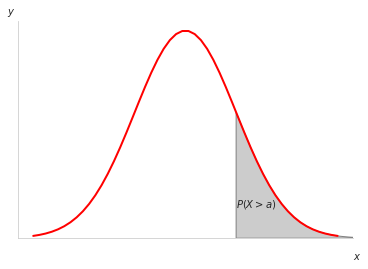

In [49]:
loi = scs.norm(3,1)
plot_proba(4,8,loi)

## Context

## Use cases

## Limites

# Théorie

# Pratique

##### Imports

<center> <h1>Take away</h1> </center>

<img src="./images/coffee.png" width="200">


__Expresso__ : 

* point 1
* point 2

__Sugar Story__ :

* point 1
* point 2

# Get more on my github <img src="./images/github.png" width="100">
https://github.com/JJublanc/statistics_tools